<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Ali Ghelichkhani
### Student Number : 
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
import os
from skimage import io, transform
from matplotlib import image as mat_image
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_utils.py to data_utils.py


# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [ ]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.rename(columns = {'name':'pic_name'}, inplace = True)
df.head()

efigi_png downloaded!
efigi_tables downloaded!


,pic_name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


Text(0.5, 0.98, 'samples')

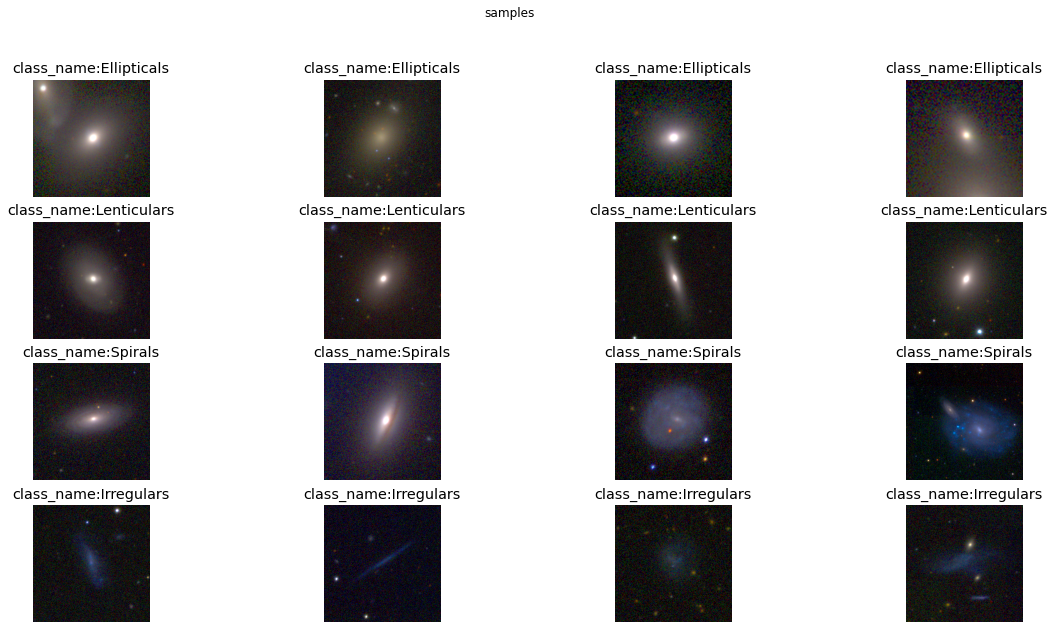

In [7]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
from IPython.display import Image, display
import cv2
import matplotlib.pyplot as plt

fig, array=plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
array=array.flatten()

count = 0
all_count = 0
pic_class=0
for i, j in df.iterrows():
    if j.class_label == pic_class:
      img = cv2.imread(filename='./efigi-1.6/png/' + str(j.pic_name) + '.png')
      array[all_count].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      array[all_count].set_xticks([])
      array[all_count].set_yticks([])
      array[all_count].set_title("class_name:{}".format(j.class_name))
      count = count + 1
      all_count = all_count + 1
      if count == 4:
        if pic_class == 3:
          break
        else:
          count = 0
          pic_class = pic_class + 1
plt.suptitle("samples")




# Define Dataset (20 Points)

In [8]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, images, path, transform):
        self.images = images.dataset.iloc[images.indices]
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = mat_image.imread(self.path + self.images.iloc[idx]['pic_name'] + ".png")
        label = self.images.iloc[idx]['class_label']
        return self.transform(image), label

# Define Model (20 Points)

In [9]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_block = nn.Sequential(
            nn.Linear(255*255*3, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, 4),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_block(x)
        return x

# Train Model (30 Points)

In [10]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
path = "./efigi-1.6/png/"


num_threads = 2
batch_size  = 32    
valid_ratio = 0.1   
test_ratio = 0.1
train_ratio = 1-(test_ratio + valid_ratio)
train_data, valid_data, test_data = random_split(df, [train_ratio, valid_ratio, test_ratio])

train_dataset = GalaxyDataSet(train_data, path, transforms.ToTensor())
valid_dataset = GalaxyDataSet(valid_data, path, transforms.ToTensor())
test_dataset  = GalaxyDataSet(test_data, path, transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_threads)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_threads)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=num_threads)

In [11]:
def model_train(model, loader, f_loss, optimizer, device):
    model.train()

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def model_test(model, loader, f_loss, device):
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            N += inputs.shape[0]
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
            f1 = f1_score(targets.cpu(), predicted_targets.cpu(), average='micro')
            
        return tot_loss/N, correct/N, f1

model = ClassifierModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
f_loss = torch.nn.CrossEntropyLoss()
print(model)

ClassifierModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_block): Sequential(
    (0): Linear(in_features=195075, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [12]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
epochs = 8
val_loss_list = []
val_acc_list = []
train_loss_list = []
train_acc_list = []
for t in range(epochs):
    print("epoch {}".format(t + 1))
    model_train(model, train_loader, f_loss, optimizer, device)
    val_loss, val_acc, val_f1 = model_test(model, valid_loader, f_loss, device)
    train_loss, train_acc, train_f1 = model_test(model, train_loader, f_loss, device)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(" Training loss: {:.4f}, Training accuracy: {:.4f}, Training f1-score: {:.4f}".format(train_loss, train_acc, val_f1))
    print(" Validation loss: {:.4f}, Validation accuracy: {:.4f}, Validation f1-score: {:.4f}".format(val_loss, val_acc, train_f1))


epoch 1
 Training loss: 0.6834, Training accuracy: 0.7496, Training f1-score: 0.7667
 Validation loss: 0.7539, Validation accuracy: 0.7444, Validation f1-score: 0.7333
epoch 2
 Training loss: 0.5020, Training accuracy: 0.8169, Training f1-score: 0.6667
 Validation loss: 0.6350, Validation accuracy: 0.7623, Validation f1-score: 0.8000
epoch 3
 Training loss: 0.4115, Training accuracy: 0.8705, Training f1-score: 0.6333
 Validation loss: 0.6835, Validation accuracy: 0.7422, Validation f1-score: 0.9333
epoch 4
 Training loss: 0.3057, Training accuracy: 0.9010, Training f1-score: 0.6000
 Validation loss: 0.7528, Validation accuracy: 0.6951, Validation f1-score: 0.9333
epoch 5
 Training loss: 0.0976, Training accuracy: 0.9748, Training f1-score: 0.6000
 Validation loss: 0.5568, Validation accuracy: 0.7735, Validation f1-score: 0.9333
epoch 6
 Training loss: 0.0885, Training accuracy: 0.9720, Training f1-score: 0.7333
 Validation loss: 0.7967, Validation accuracy: 0.7646, Validation f1-score:

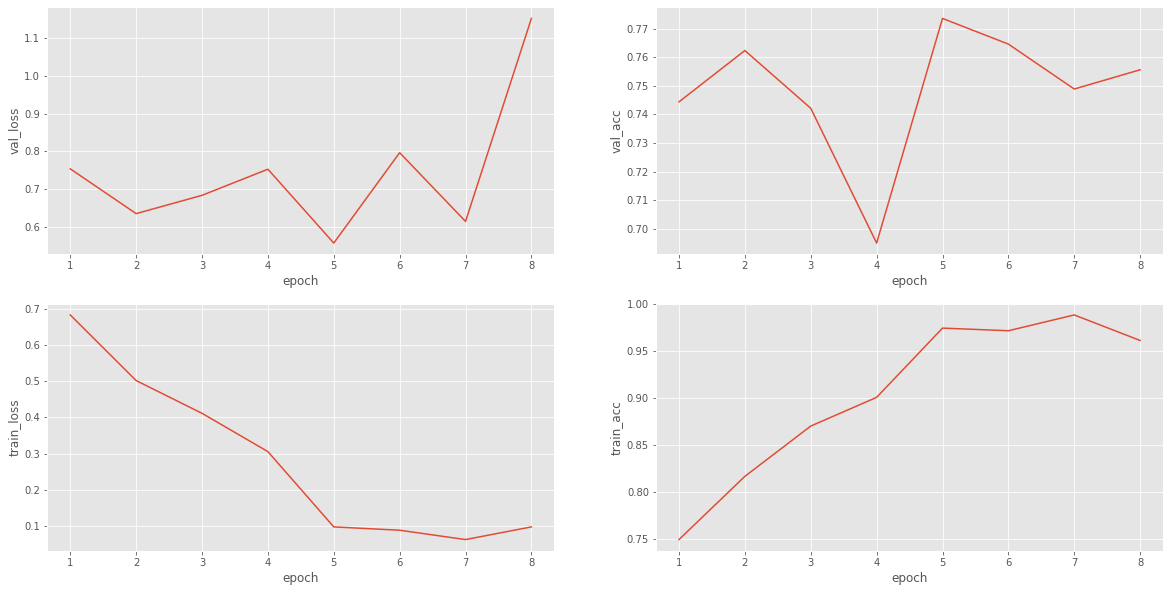

In [13]:
fig, array=plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
array=array.flatten()

array[0].plot([1,2,3,4,5,6,7,8], val_loss_list)
array[0].set_xlabel('epoch')
array[0].set_ylabel('val_loss')

array[1].plot([1,2,3,4,5,6,7,8], val_acc_list)
array[1].set_xlabel('epoch')
array[1].set_ylabel('val_acc')

array[2].plot([1,2,3,4,5,6,7,8], train_loss_list)
array[2].set_xlabel('epoch')
array[2].set_ylabel('train_loss')

array[3].plot([1,2,3,4,5,6,7,8], train_acc_list)
array[3].set_xlabel('epoch')
array[3].set_ylabel('train_acc')

plt.show()

# Test Model (20)

 Test loss: 1.3480, Test accuracy: 0.7528, Test f1-Score: 0.7241


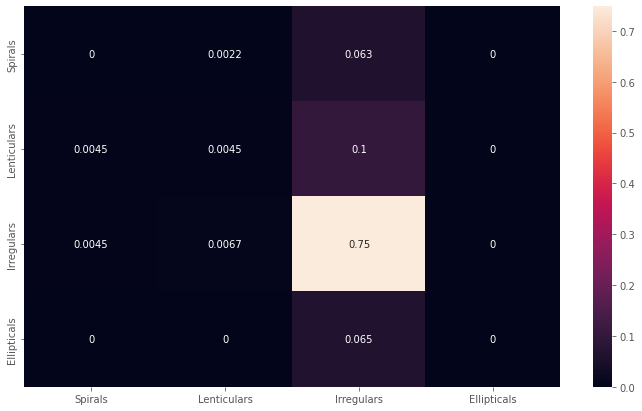

In [14]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
test_loss, test_acc, test_f1 = model_test(model, test_loader, f_loss, device)
print(" Test loss: {:.4f}, Test accuracy: {:.4f}, Test f1-Score: {:.4f}".format(test_loss, test_acc, test_f1))


y_pred = []
y_true = []

# iterate over test data
for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = targets.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Spirals', 'Lenticulars', 'Irregulars','Ellipticals')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()
